# Bayesian Causal Inference

In [5]:
!pip install arviz

# Imports

In [6]:
import numpy as np
import pystan
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt


# Data Generating Process

Math TBD

In [7]:
class DataGeneratingProcess:
    
    """
    Generates sample data for causal inference 

    Parameters
    ----------
    N :  number of observations
    alpha : intercept in the Y model
    tau : treatment effect
    rho:  correlation between the errors
    treatment_assignment : unconfounded vs confounded treatment assignment. If treatment is counfounded, then the assignment
                           mechanism is: (i) unknown, (ii) not independent of potential outcomes, (iii) probabilistic 
                           (conditional on covariates, probability of receiving treatment is strictly between zero and one 
                           for all units)
    """
    
    def __init__(self, N: int = 500, alpha: float = 1.0, tau: float = 0.25, 
                 rho: float = 0.0, covariates: bool = False,  
                 treatment_assignment: str = 'u', seed: int = 42):

        self.N = N
        self.alpha = alpha
        self.tau = tau
        self.rho = rho
        self.covariates = covariates
        self.treatment_assignment = treatment_assignment
        self.seed = seed

    def __repr__(self):
            
            items = ("%s = %r" % (k, v) for k, v in self.__dict__.items())
            return "<%s: {%s}>" % (self.__class__.__name__, ', '.join(items))

    def generate_data(self):

        np.random.seed(self.seed)

        sd_c = 1 # SD for the control
        sd_t = 1 # SD for the treated

        cov_mat = np.array([[sd_c**2, self.rho*sd_c*sd_t], 
                            [self.rho*sd_c*sd_t, sd_t**2]])

        if self.covariates:

            X = np.random.normal(0.0, 1.0, size=(self.N, 5))
            #beta_c = np.random.normal(0.0, 1.0, 5)
            #beta_t = np.random.normal(0.0, 1.0, 5)
            #beta_c[2:4] = 0.0
            #beta_t[0:2] = 0.0
            beta_c = np.array([1.5, 0.5, -1.0,  0.0, 0.0])
            beta_t = np.array([0.0, 0.0, -1.0, 0.5, 1.5])
            Xbeta_c = np.matmul(X, beta_c)
            Xbeta_t = np.matmul(X, beta_t)
            
            mu_c = self.alpha + Xbeta_c + 0 * self.tau; # mean for the control
            mu_t = self.alpha + Xbeta_t + 1 * self.tau; # mean for the treated

            self.beta_c = beta_c
            self.beta_t = beta_t          

            science = np.empty([self.N, 2])
            for i in range(self.N):
                science[i,:] = np.random.multivariate_normal(mean = [mu_c[i], mu_t[i]], cov = cov_mat, size = 1) 

            if self.treatment_assignment == 'u':
                W = np.random.choice([0,1], size = self.N) # binary treatment variable (uniform probs across treatments)
            
            elif self.treatment_assignment == 'c':
                # Undividuals who benefit from treatment are more likely to be treated
                # X5 is positively related to likelihood of treatment
                ps = np.exp(-0.2 + X[:,4])/(1 + np.exp(-0.2 + X[:,4])) # true propensity score
           
        else:
            if self.treatment_assignment == 'c':
                raise ValueError("treatment_assignment = 'c' not valid when covariates = False")
      
            mu_c = self.alpha + 0 * self.tau; # mean and SD for the control
            mu_t = self.alpha + 1 * self.tau; 
            science = np.random.multivariate_normal(mean = [mu_c, mu_t], cov = cov_mat, size = self.N)
            W = np.random.choice([0,1], size = self.N) # binary treatment variable (uniform probs across treatments)
        
        Y0 = science[:, 0]  # potential outcome if W = 0
        Y1 = science[:, 1]  # potential outcome if W = 1
        tau_unit = Y1 - Y0  # unit-level treatment effect
        
        if self.treatment_assignment == 'u':
            W = np.random.choice([0,1], size = self.N) # binary treatment variable (uniform probs across treatments)
            
        elif self.treatment_assignment == 'c':
            # Undividuals who benefit from treatment are more likely to be treated
            # X5 is positively related to likelihood of treatment
            ps = np.exp(-0.2 + X[:,4])/(1 + np.exp(-0.2 + X[:,4])) # true propensity score

            #tau_unit_cdf = norm.cdf(tau_unit)
            W = np.empty([self.N], dtype=int)
            for i in range(len(W)):
                W[i] = np.random.choice([0,1], size = 1, p = [1-ps[i], ps[i]]) 
          
        # The realization of potential outcomes by the assignment mechanism
        Y_obs = Y0 * (1 - W) + Y1 * W
        Y_mis = Y0 * W + Y1 * (1 - W)

        df = pd.DataFrame({'y_obs':Y_obs, 'y_mis': Y_mis, 'y0':Y0, 'y1': Y1, 'tau_unit': tau_unit, 'w':W})

        if self.covariates:
            X_df = pd.DataFrame(X, columns=['X1','X2','X3','X4','X5'])
            df = df.join(X_df) 

        self.df = df
    
        return self 


In [8]:
### Test

seed=432

dgp = DataGeneratingProcess(covariates=True, treatment_assignment = 'u', seed=seed)
r = dgp.generate_data()
df = r.df

print(np.unique(df['w'], return_counts=True))

df = pd.DataFrame({'W':df['w'], 'y_obs' : df['y_obs']})     
print(df.groupby('W').mean())

dgp = DataGeneratingProcess(covariates=True, treatment_assignment = 'c', seed=seed)
r = dgp.generate_data()
df = r.df

print(np.unique(df['w'], return_counts=True))

df = pd.DataFrame({'W':df['w'], 'y_obs' : df['y_obs']})     
print(df.groupby('W').mean())



(array([0, 1]), array([240, 260]))
      y_obs
W          
0  1.072989
1  0.950468
(array([0, 1]), array([287, 213]))
      y_obs
W          
0  0.812148
1  2.099246


# 1. Randomized experiment without covariates

## 1.1. Sample data

In [9]:
dgp = DataGeneratingProcess(seed=12345)
df1 = dgp.generate_data().df
df1

,y_obs,y_mis,y0,y1,tau_unit,w
0,0.795292,1.728943,0.795292,1.728943,0.933651,0
1,0.480561,0.694270,0.480561,0.694270,0.213708,0
2,2.643406,2.965781,2.965781,2.643406,-0.322375,1
3,1.531746,1.092908,1.092908,1.531746,0.438838,1
4,1.769023,2.496435,1.769023,2.496435,0.727412,0
...,...,...,...,...,...,...
495,2.848291,0.254395,0.254395,2.848291,2.593896,1
496,0.086600,3.652912,0.086600,3.652912,3.566312,0
497,0.410640,1.357657,0.410640,1.357657,0.947018,0
498,0.090074,0.860702,0.860702,0.090074,-0.770628,1


## 1.2. Fit Model

In [10]:
simulated_example = """

data {
  int<lower=0> N;                   // sample size
  vector[N] y;                      // observed outcome
  vector[N] w;                      // treatment assigned
  real<lower=-1,upper=1> rho;       // assumed correlation between the potential outcomes
}
parameters {
  real alpha;                       // intercept
  real tau;                         // super-population average treatment effect
  real<lower=0> sigma_c;            // residual SD for the control
  real<lower=0> sigma_t;            // residual SD for the treated
}
model {
   // PRIORS
   alpha ~ normal(0, 5);            
   tau ~ normal(0, 5);
   sigma_c ~ normal(0, 5);          
   sigma_t ~ normal(0, 5);

   // LIKELIHOOD
   y ~ normal(alpha + tau*w, sigma_t*w + sigma_c*(1 - w));
}
generated quantities{
  real tau_fs;                      // finite-sample average treatment effect  
  real y0[N];                       // potential outcome if W = 0
  real y1[N];                       // potential outcome if W = 1
  real tau_unit[N];                 // unit-level treatment effect
  for(n in 1:N){
    real mu_c = alpha;            
    real mu_t = alpha + tau;      
    if(w[n] == 1){                
      y0[n] = normal_rng(mu_c + rho*(sigma_c/sigma_t)*(y[n] - mu_t), sigma_c*sqrt(1 - rho^2)); 
      y1[n] = y[n];
    }else{                        
      y0[n] = y[n];       
      y1[n] = normal_rng(mu_t + rho*(sigma_t/sigma_c)*(y[n] - mu_c), sigma_t*sqrt(1 - rho^2)); 
    }
    tau_unit[n] = y1[n] - y0[n];
  }
  tau_fs = mean(tau_unit);        
}

"""

In [11]:
stan_data1 = {'N':df1.shape[0], 'y':df1.y_obs, 'w':df1.w, 'rho':0.0}
sm1 = pystan.StanModel(model_code=simulated_example)
fit1 = sm1.sampling(data=stan_data1, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_384bd7d86f218945cd76179a6faaa753 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## 1.3. Results

In [12]:
#print(fit)
summary_dict = fit1.summary()
#pars = fit.model_pars
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

df.loc[["alpha", "tau", "tau_fs", "sigma_c", "sigma_t"]]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,1.029552,0.001677,0.061881,0.911718,0.989783,1.027673,1.071892,1.154690,1362.248554,0.999968
tau,0.222783,0.002401,0.086670,0.049028,0.164715,0.225317,0.281668,0.385602,1302.514041,1.002737
tau_fs,0.225520,0.001494,0.059960,0.104208,0.185244,0.226522,0.265273,0.346139,1611.539605,0.999598
sigma_c,0.957223,0.000985,0.043764,0.874038,0.927653,0.956082,0.984840,1.047381,1975.788099,1.000683
sigma_t,0.944845,0.000988,0.042501,0.865190,0.915877,0.943799,0.973423,1.031758,1851.452370,0.999445


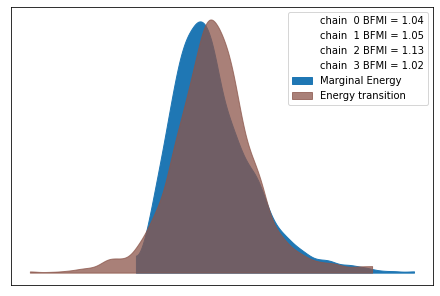

In [13]:
inf_data = az.convert_to_inference_data(fit1)
az.plot_energy(inf_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f135b890a90>,
      dtype=object)

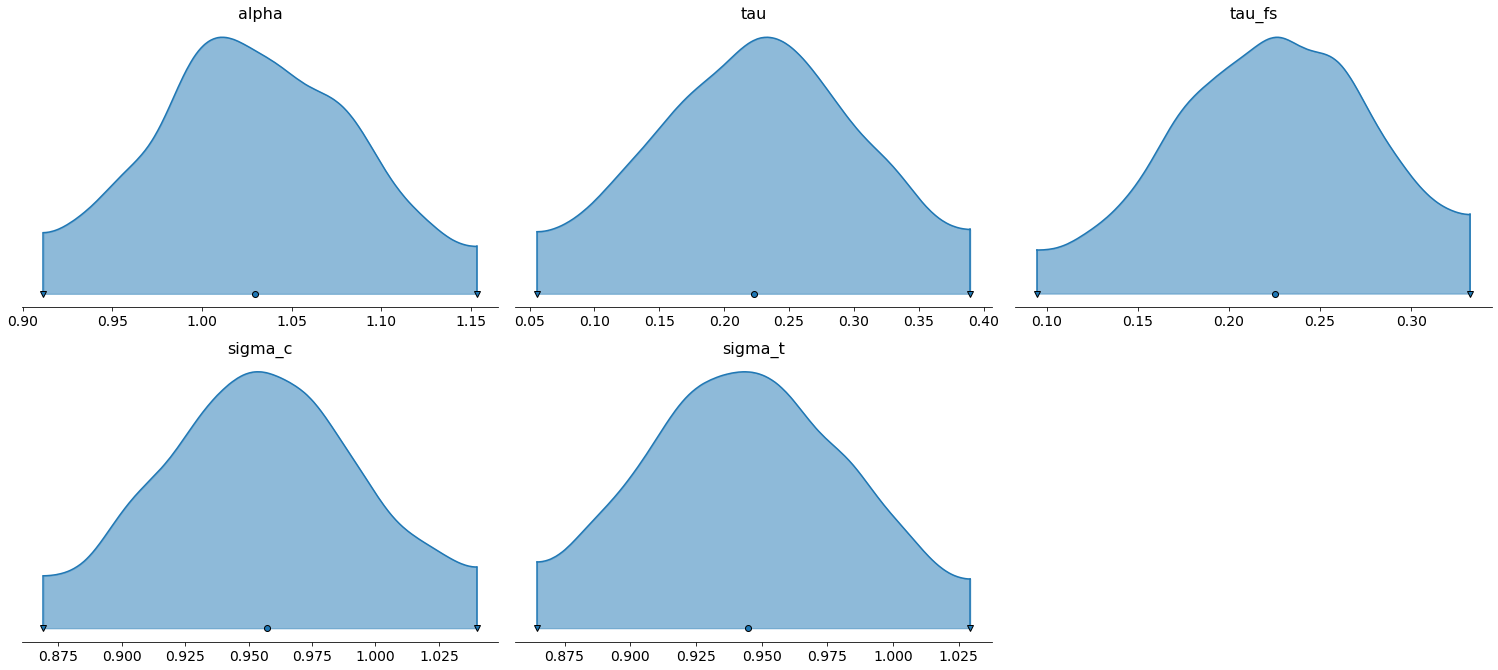

In [14]:
az.plot_density(inf_data, var_names = ["alpha", "tau", "tau_fs", "sigma_c", "sigma_t"], hdi_prob =.95, hdi_markers='v', shade =.5)

In [15]:
## return an array of three dimensions: iterations, chains, parameters
posterior = fit1.extract(permuted=False)
print(posterior.shape)

(500, 4, 1506)


In [16]:
# Collect MCMC samples for the missing potential outcomes
mcmc = fit1.extract(permuted=True)
mcmc['y0'].shape # 2000 samples (4 chains x 500 each) x for each of the 500 obs

(2000, 500)

In [17]:
mcmc['y0'][:,0].shape # all samples for first obs

(2000,)

In [18]:
mcmc['y0'][:,0] # becuase first obs is w=0 => all values comes from y_obs, whereas mcmc['y1'][:,0] comes from the posterior distribition of missing values

array([0.79529234, 0.79529234, 0.79529234, ..., 0.79529234, 0.79529234,
       0.79529234])

In [19]:
mcmc['y1'][:,0]

array([0.95516739, 0.09313324, 0.24836934, ..., 2.88904433, 1.58212788,
       0.62030421])

# 2. Randomized experiment with covariates

## 2.1. Sample Data 

In [20]:
dgp = DataGeneratingProcess(covariates=True, seed=12345)
r = dgp.generate_data()
df2 = r.df
df2

,y_obs,y_mis,y0,y1,tau_unit,w,X1,X2,X3,X4,X5
0,6.266737,0.519771,0.519771,6.266737,5.746966,1,-0.204708,0.478943,-0.519439,-0.555730,1.965781
1,2.383818,2.624701,2.624701,2.383818,-0.240883,1,1.393406,0.092908,0.281746,0.769023,1.246435
2,0.617474,3.833803,0.617474,3.833803,3.216329,0,1.007189,-1.296221,0.274992,0.228913,1.352917
3,0.922897,2.223415,0.922897,2.223415,1.300517,0,0.886429,-2.001637,-0.371843,1.669025,-0.438570
4,-1.265838,-2.598899,-2.598899,-1.265838,1.333061,1,-0.539741,0.476985,3.248944,-1.021228,-0.577087
...,...,...,...,...,...,...,...,...,...,...,...
495,1.219681,-2.616722,-2.616722,1.219681,3.836402,1,-2.490860,0.468027,-0.343683,-1.428207,0.969402
496,3.932656,3.055717,3.055717,3.932656,0.876938,1,-1.026410,1.097896,-2.216861,-1.681929,-0.375497
497,0.241502,2.212151,0.241502,2.212151,1.970649,0,-0.764114,1.500305,1.256951,1.685727,0.722659
498,1.025913,2.117330,2.117330,1.025913,-1.091416,1,0.940711,0.594283,0.186224,-0.656066,0.379592


In [21]:
# Add interaction effects between covariates and treatment
df2[["wX1", "wX2", "wX3", "wX4", "wX5"]] = df2[["X1", "X2", "X3", "X4", "X5"]].multiply(df2["w"], axis="index")
df2

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,y_obs,y_mis,y0,y1,tau_unit,w,X1,X2,X3,X4,X5,wX1,wX2,wX3,wX4,wX5
0,6.266737,0.519771,0.519771,6.266737,5.746966,1,-0.204708,0.478943,-0.519439,-0.555730,1.965781,-0.204708,0.478943,-0.519439,-0.555730,1.965781
1,2.383818,2.624701,2.624701,2.383818,-0.240883,1,1.393406,0.092908,0.281746,0.769023,1.246435,1.393406,0.092908,0.281746,0.769023,1.246435
2,0.617474,3.833803,0.617474,3.833803,3.216329,0,1.007189,-1.296221,0.274992,0.228913,1.352917,0.000000,-0.000000,0.000000,0.000000,0.000000
3,0.922897,2.223415,0.922897,2.223415,1.300517,0,0.886429,-2.001637,-0.371843,1.669025,-0.438570,0.000000,-0.000000,-0.000000,0.000000,-0.000000
4,-1.265838,-2.598899,-2.598899,-1.265838,1.333061,1,-0.539741,0.476985,3.248944,-1.021228,-0.577087,-0.539741,0.476985,3.248944,-1.021228,-0.577087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.219681,-2.616722,-2.616722,1.219681,3.836402,1,-2.490860,0.468027,-0.343683,-1.428207,0.969402,-2.490860,0.468027,-0.343683,-1.428207,0.969402
496,3.932656,3.055717,3.055717,3.932656,0.876938,1,-1.026410,1.097896,-2.216861,-1.681929,-0.375497,-1.026410,1.097896,-2.216861,-1.681929,-0.375497
497,0.241502,2.212151,0.241502,2.212151,1.970649,0,-0.764114,1.500305,1.256951,1.685727,0.722659,-0.000000,0.000000,0.000000,0.000000,0.000000
498,1.025913,2.117330,2.117330,1.025913,-1.091416,1,0.940711,0.594283,0.186224,-0.656066,0.379592,0.940711,0.594283,0.186224,-0.656066,0.379592


## 2.2. Fit Model

In [22]:
simulated_example2 = """

data {
  int<lower=0> N;                   // sample size
  int<lower=0> N_cov;               // number of covariates
  vector[N] y;                      // observed outcome
  vector[N] w;                      // treatment assigned
  matrix[N, N_cov] x;               // covariates
  matrix[N, N_cov] xw_inter;        // interaction terms
  real<lower=-1,upper=1> rho;       // assumed correlation between the potential outcomes
}
parameters {
  real alpha;                       // intercept
  vector[N_cov] beta;               // coefficients for x[N]
  vector[N_cov] beta_inter;         // coefficients for x_inter[N] 
  real tau;                         // super-population average treatment effect
  real<lower=0> sigma_c;            // residual SD for the control
  real<lower=0> sigma_t;            // residual SD for the treated
}
model {
   // PRIORS
   alpha ~ normal(0, 5); 
   beta ~ normal(0, 100);
   beta_inter ~ normal(0, 100);           
   tau ~ normal(0, 5);
   sigma_c ~ normal(0, 5);          
   sigma_t ~ normal(0, 5);

   // LIKELIHOOD
   y ~ normal(alpha + x*beta + xw_inter*beta_inter + tau * w, sigma_t*w + sigma_c*(1-w));
}
generated quantities{
  real tau_fs;                      // finite-sample average treatment effect  
  real y0[N];                       // potential outcome if W = 0
  real y1[N];                       // potential outcome if W = 1
  real tau_unit[N];                 // unit-level treatment effect
  for(n in 1:N){
    real mu_c = alpha + x[n,]*beta;        
    real mu_t = alpha + x[n,]*beta + x[n, ]*beta_inter + tau;
    if(w[n] == 1){                
      y0[n] = normal_rng(mu_c + rho*(sigma_c/sigma_t)*(y[n] - mu_t), sigma_c*sqrt(1 - rho^2)); 
      y1[n] = y[n];
    }else{                        
      y0[n] = y[n];       
      y1[n] = normal_rng(mu_t + rho*(sigma_t/sigma_c)*(y[n] - mu_c), sigma_t*sqrt(1 - rho^2)); 
    }
    tau_unit[n] = y1[n] - y0[n];
  }
  tau_fs = mean(tau_unit);        
}

"""

In [23]:
stan_data2 = {'N': df2.shape[0], 
              'y': df2.y_obs,
              'w': df2.w,
              'x': df2[["X1", "X2", "X3", "X4", "X5"]].values,
              'xw_inter': df2[["wX1", "wX2", "wX3", "wX4", "wX5"]].values,
              'N_cov':5,
              'rho':0.0}
sm2 = pystan.StanModel(model_code=simulated_example2)
fit2 = sm2.sampling(data=stan_data2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4f2f6fe70cd756ee463371850bc520c NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## 2.3. Results

In [24]:
#print(fit)
pars = fit2.model_pars
print(pars)
summary_dict = fit2.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df.loc[["alpha", "tau", "tau_fs", "beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]",
        "beta_inter[1]", "beta_inter[2]", "beta_inter[3]", "beta_inter[4]", "beta_inter[5]", 
        "sigma_c", "sigma_t"]]

['alpha', 'beta', 'beta_inter', 'tau', 'sigma_c', 'sigma_t', 'tau_fs', 'y0', 'y1', 'tau_unit']


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,1.083410,0.001513,0.071146,0.948068,1.036419,1.083413,1.131155,1.218551,2209.886520,0.999022
tau,0.185054,0.002172,0.099609,-0.007643,0.117283,0.185529,0.253807,0.380269,2103.331244,0.998699
tau_fs,0.261120,0.001574,0.071217,0.123089,0.211682,0.259399,0.310604,0.399371,2047.643092,0.999533
beta[1],1.435509,0.001364,0.068074,1.296841,1.390648,1.435521,1.479818,1.572084,2492.521941,0.999371
beta[2],0.572044,0.001372,0.066468,0.443021,0.525755,0.572053,0.620098,0.693356,2346.394839,0.998228
beta[3],-0.989262,0.001511,0.071611,-1.131195,-1.036600,-0.990521,-0.941334,-0.850565,2244.931776,0.998908
beta[4],0.054562,0.001394,0.069445,-0.077243,0.006549,0.053787,0.100076,0.194178,2480.365501,0.998557
beta[5],0.012837,0.001566,0.075013,-0.136927,-0.036974,0.012527,0.063474,0.159840,2294.778028,0.999127
beta_inter[1],-1.309609,0.001811,0.093586,-1.492078,-1.373694,-1.312910,-1.247394,-1.123351,2671.630637,1.000207
beta_inter[2],-0.605007,0.001908,0.093016,-0.784869,-0.668166,-0.605629,-0.541934,-0.426648,2376.018010,0.998765


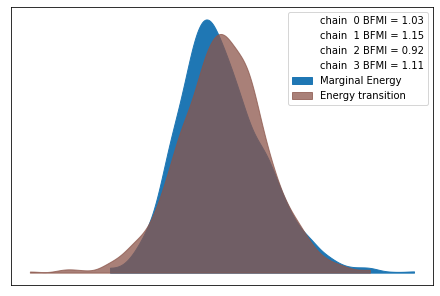

In [25]:
inf_data = az.convert_to_inference_data(fit2)
az.plot_energy(inf_data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f135db5f908>,
      dtype=object)

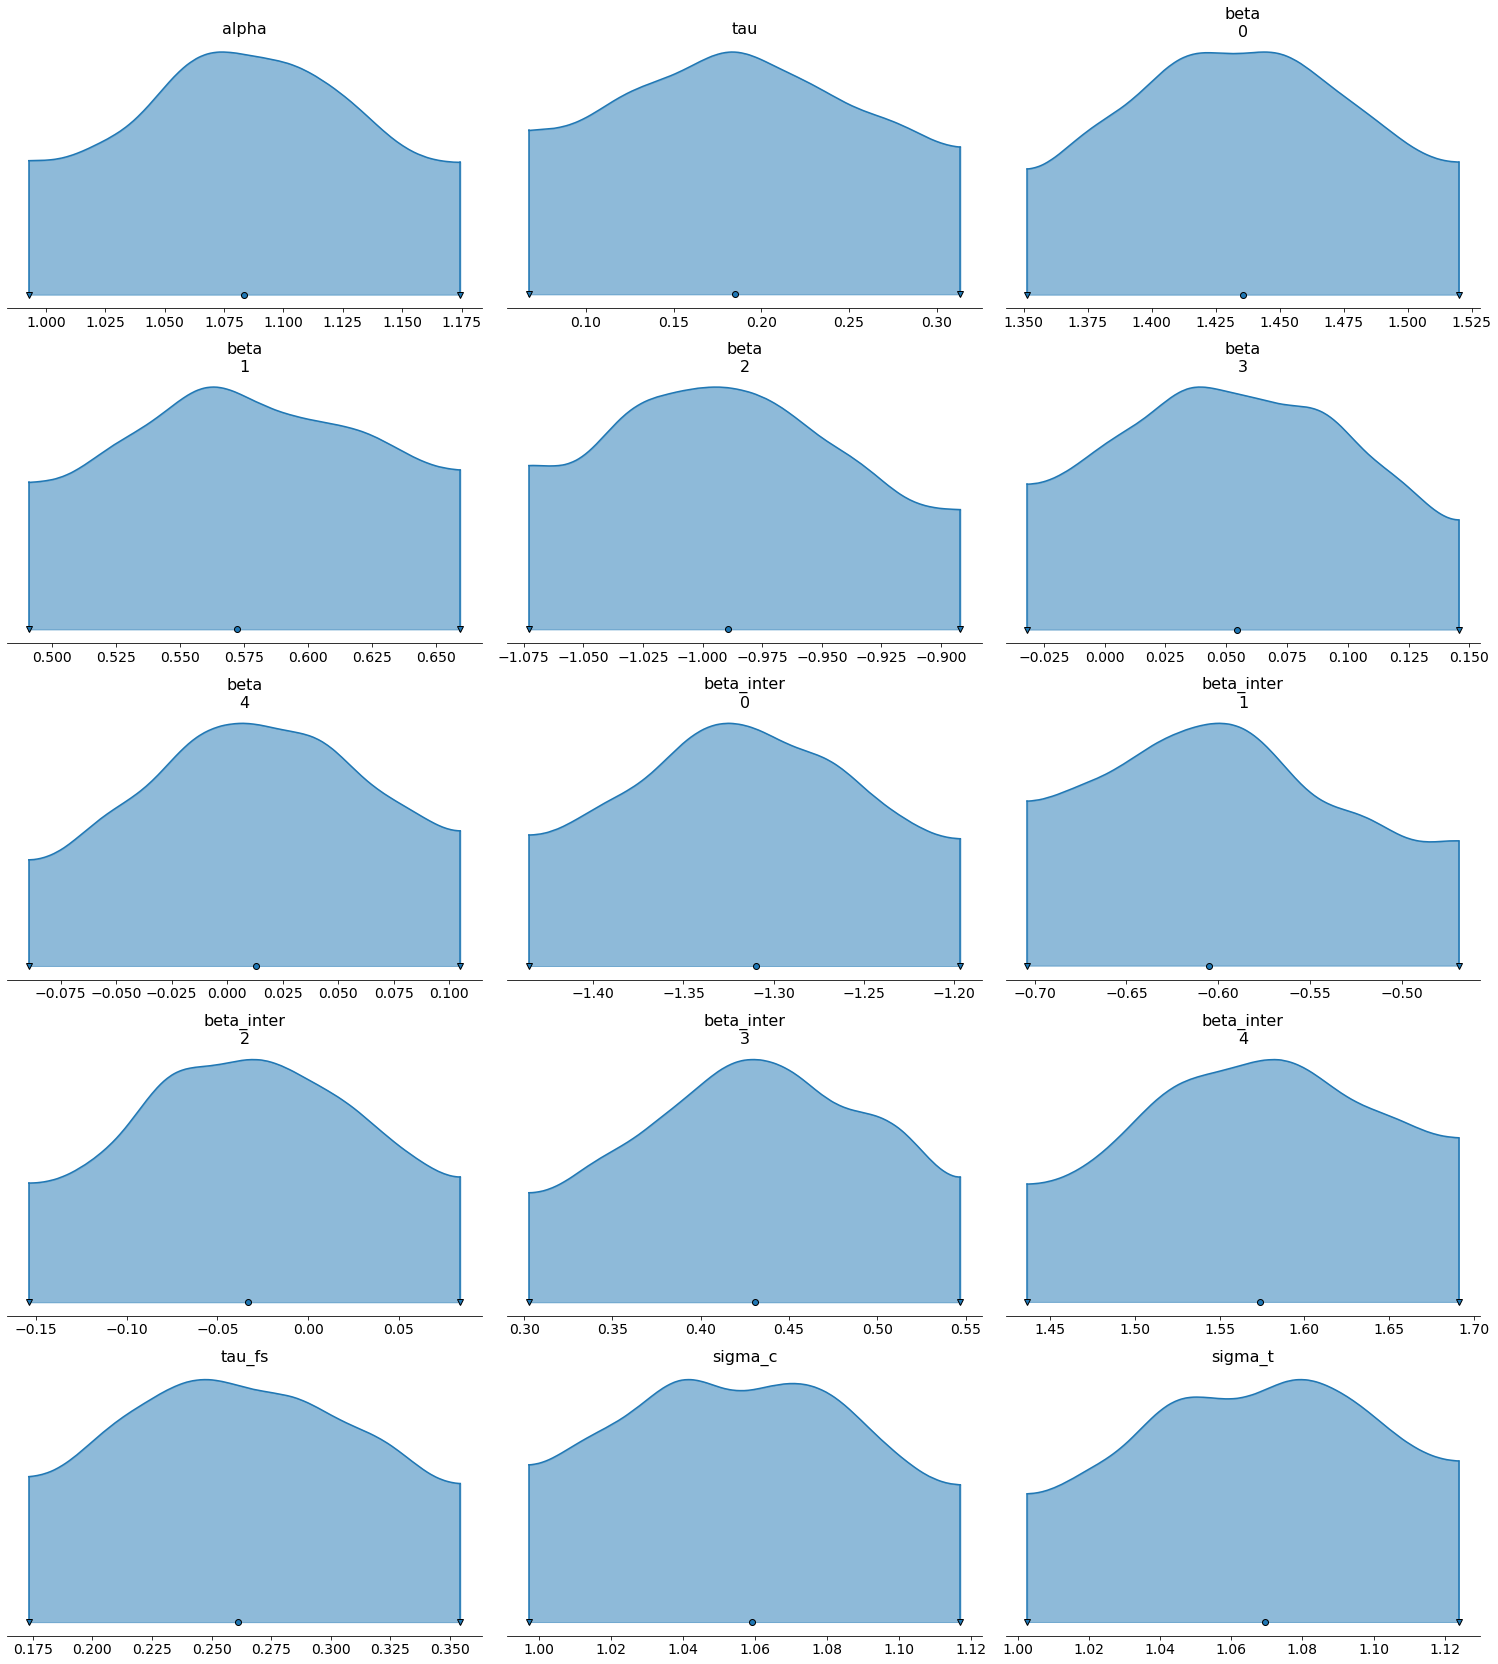

In [26]:
az.plot_density(inf_data, var_names = ["alpha", "tau", "beta", "beta_inter", "tau_fs", "sigma_c", "sigma_t"], 
                hdi_prob =.80, hdi_markers='v', shade =.5)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

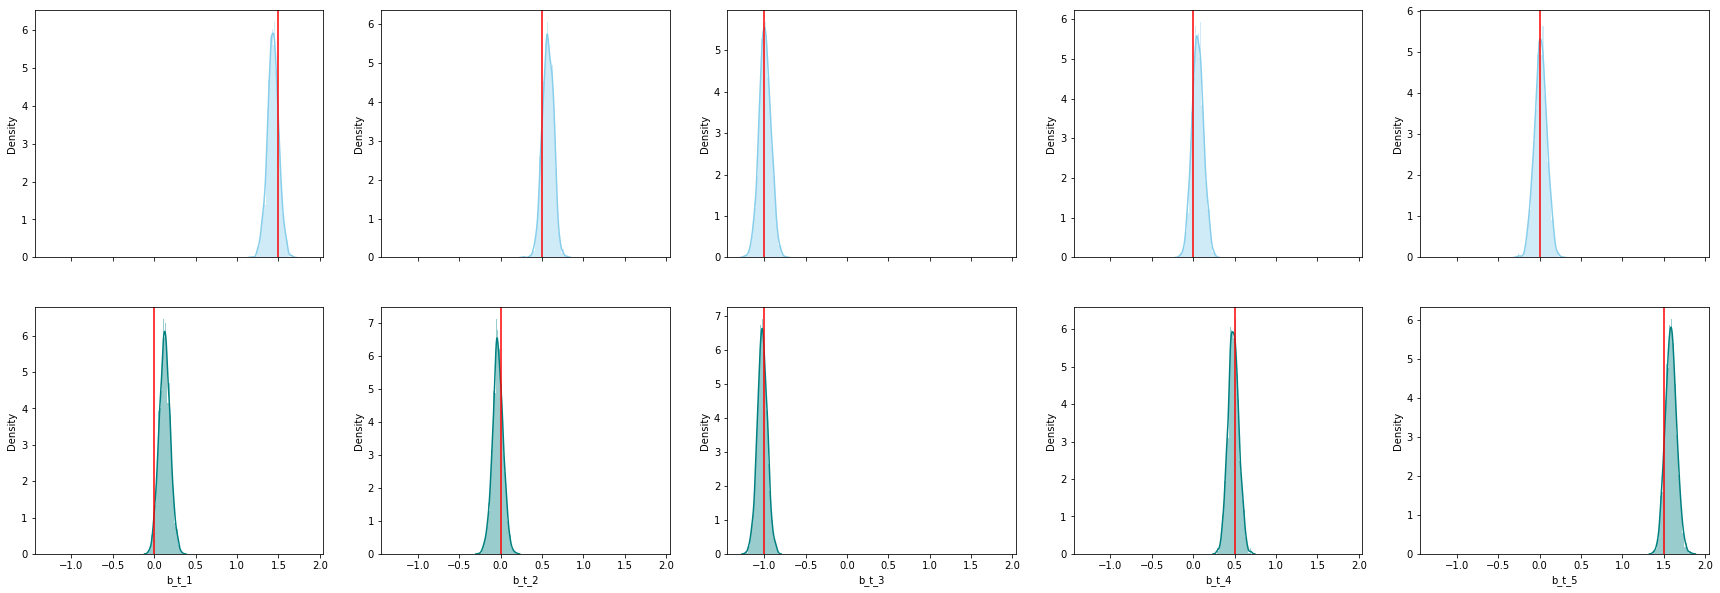

In [27]:
samples = fit2.extract(permuted=True)

# Since the beta_inter represents the difference bewteen beta_t - beta_c, and beta = beta_c, we can derive beta_t = beta_inter + beta_c
post_beta_c = pd.DataFrame(samples['beta'], columns=['b_c_1','b_c_2','b_c_3','b_c_4','b_c_5']) # 2000 samples (4 chains x 500 each -> half of inter=1000)
post_beta_t = pd.DataFrame(samples['beta_inter'] + samples['beta'], columns=['b_t_1','b_t_2','b_t_3','b_t_4','b_t_5'])

# Plot true vs posterior distribution for each beta
f, axes = plt.subplots(2, 5, figsize=(30, 10), sharex=True)

plc1 = sns.distplot(post_beta_c["b_c_1"] , color="skyblue", ax=axes[0, 0])
plc1.axvline(r.beta_c[0], color='r')
plc2 = sns.distplot(post_beta_c["b_c_2"] , color="skyblue", ax=axes[0, 1])
plc2.axvline(r.beta_c[1], color='r')
plc3 = sns.distplot(post_beta_c["b_c_3"] , color="skyblue", ax=axes[0, 2])
plc3.axvline(r.beta_c[2], color='r')
plc4 = sns.distplot(post_beta_c["b_c_4"] , color="skyblue", ax=axes[0, 3])
plc4.axvline(r.beta_c[3], color='r')
plc5 = sns.distplot(post_beta_c["b_c_5"] , color="skyblue", ax=axes[0, 4])
plc5.axvline(r.beta_c[4], color='r')

plt1 = sns.distplot(post_beta_t["b_t_1"] , color="teal", ax=axes[1, 0])
plt1.axvline(r.beta_t[0], color='r')
plt2 = sns.distplot(post_beta_t["b_t_2"] , color="teal", ax=axes[1, 1])
plt2.axvline(r.beta_t[1], color='r')
plt3 = sns.distplot(post_beta_t["b_t_3"] , color="teal", ax=axes[1, 2])
plt3.axvline(r.beta_t[2], color='r')
plt4 = sns.distplot(post_beta_t["b_t_4"] , color="teal", ax=axes[1, 3])
plt4.axvline(r.beta_t[3], color='r')
plt5 = sns.distplot(post_beta_t["b_t_5"] , color="teal", ax=axes[1, 4])
plt5.axvline(r.beta_t[4], color='r')

plt.show()



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

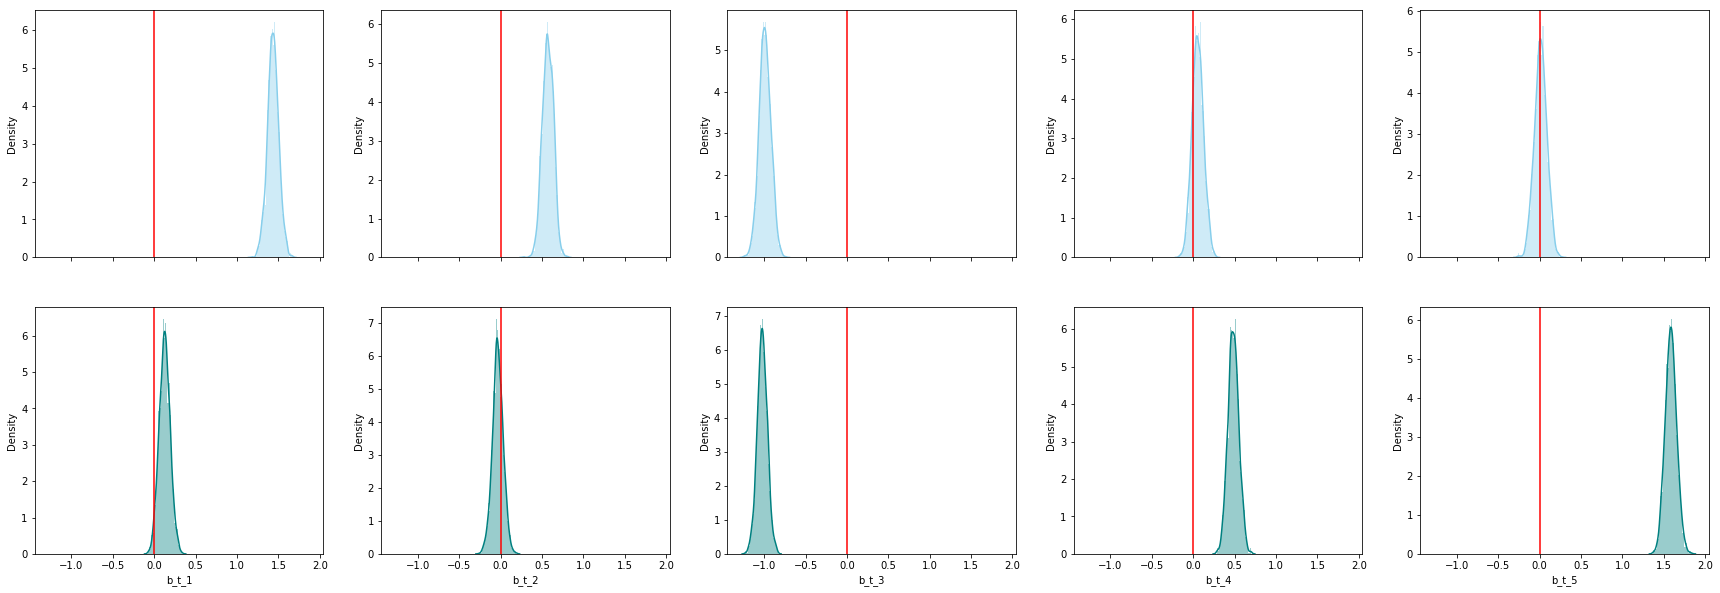

In [28]:
samples = fit2.extract(permuted=True)

# Since the beta_inter represents the difference bewteen beta_t - beta_c, and beta = beta_c, we can derive beta_t = beta_inter + beta_c
post_beta_c = pd.DataFrame(samples['beta'], columns=['b_c_1','b_c_2','b_c_3','b_c_4','b_c_5']) # 2000 samples (4 chains x 500 each -> half of inter=1000)
post_beta_t = pd.DataFrame(samples['beta_inter'] + samples['beta'], columns=['b_t_1','b_t_2','b_t_3','b_t_4','b_t_5'])

# Plot posterior distribution for each beta vs zero
f, axes = plt.subplots(2, 5, figsize=(30, 10), sharex=True)

plc1 = sns.distplot(post_beta_c["b_c_1"] , color="skyblue", ax=axes[0, 0])
plc1.axvline(0, color='r')
plc2 = sns.distplot(post_beta_c["b_c_2"] , color="skyblue", ax=axes[0, 1])
plc2.axvline(0, color='r')
plc3 = sns.distplot(post_beta_c["b_c_3"] , color="skyblue", ax=axes[0, 2])
plc3.axvline(0, color='r')
plc4 = sns.distplot(post_beta_c["b_c_4"] , color="skyblue", ax=axes[0, 3])
plc4.axvline(0, color='r')
plc5 = sns.distplot(post_beta_c["b_c_5"] , color="skyblue", ax=axes[0, 4])
plc5.axvline(0, color='r')

plt1 = sns.distplot(post_beta_t["b_t_1"] , color="teal", ax=axes[1, 0])
plt1.axvline(0, color='r')
plt2 = sns.distplot(post_beta_t["b_t_2"] , color="teal", ax=axes[1, 1])
plt2.axvline(0, color='r')
plt3 = sns.distplot(post_beta_t["b_t_3"] , color="teal", ax=axes[1, 2])
plt3.axvline(0, color='r')
plt4 = sns.distplot(post_beta_t["b_t_4"] , color="teal", ax=axes[1, 3])
plt4.axvline(0, color='r')
plt5 = sns.distplot(post_beta_t["b_t_5"] , color="teal", ax=axes[1, 4])
plt5.axvline(0, color='r')

plt.show()


## 2.4. Alternative model specification

Set control and treatment specific covariates.

In [29]:
print(r.beta_c)
print(r.beta_t)

[ 1.5  0.5 -1.   0.   0. ]
[ 0.   0.  -1.   0.5  1.5]


In [30]:
simulated_example22 = """

data {
  int<lower=0> N;                   // sample size
  int<lower=0> N_cov_c;             // number of covariates control
  int<lower=0> N_cov_t;             // number of covariates treatment
  vector[N] y;                      // observed outcome
  vector[N] w;                      // treatment assigned
  matrix[N, N_cov_c] x_c;           // covariates for control
  matrix[N, N_cov_t] x_t;           // covariates for treatment
  real<lower=-1,upper=1> rho;       // assumed correlation between the potential outcomes
}
parameters {
  real alpha;                       // intercept
  vector[N_cov_c] beta_c;           // coefficients for x_c[N]
  vector[N_cov_t] beta_t;           // coefficients for x_t[N] 
  real tau;                         // super-population average treatment effect
  real<lower=0> sigma_c;            // residual SD for the control
  real<lower=0> sigma_t;            // residual SD for the treated
}
model {
   // PRIORS
   alpha ~ normal(0, 5); 
   beta_c ~ normal(0, 10);
   beta_t ~ normal(0, 10);           
   tau ~ normal(0, 5);
   sigma_c ~ normal(0, 5);          
   sigma_t ~ normal(0, 5);

   // LIKELIHOOD
   //y ~ normal(alpha + x_c*beta_c * (1-w) + x_t*beta_t * w + tau * w, sigma_t * w + sigma_c * (1-w));
   
   for (n in 1:N) {
     if(w[n] == 0){                
      y[n] ~ normal(alpha + x_c[n]*beta_c, sigma_c);
    } else {                         
      y[n] ~ normal(alpha + x_t[n]*beta_t  + tau, sigma_t);
    }
  }
}
  
generated quantities{
  real tau_fs;                      // finite-sample average treatment effect  
  real y0[N];                       // potential outcome if W = 0
  real y1[N];                       // potential outcome if W = 1
  real tau_unit[N];                 // unit-level treatment effect
  for(n in 1:N){
    real mu_c = alpha + x_c[n,]*beta_c;        
    real mu_t = alpha + x_t[n,]*beta_t + tau;
    if(w[n] == 1){                
      y0[n] = normal_rng(mu_c + rho*(sigma_c/sigma_t)*(y[n] - mu_t), sigma_c*sqrt(1 - rho^2)); 
      y1[n] = y[n];
    }else{                        
      y0[n] = y[n];       
      y1[n] = normal_rng(mu_t + rho*(sigma_t/sigma_c)*(y[n] - mu_c), sigma_t*sqrt(1 - rho^2)); 
    }
    tau_unit[n] = y1[n] - y0[n];
  }
  tau_fs = mean(tau_unit);        
}

"""

In [31]:
stan_data2 = {'N': df2.shape[0], 
              'N_cov_c': 3,
              'N_cov_t': 3,
              'y': df2.y_obs,
              'w': df2.w,
              'x_c': df2[["X1", "X2", "X3"]].values,
              'x_t': df2[["X3", "X4", "X5"]].values,
              'rho':0.0}
sm2 = pystan.StanModel(model_code=simulated_example22)
fit2 = sm2.sampling(data=stan_data2, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_021260cddac31541bbbf2e0807b90b09 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## 2.5. Results

In [32]:
#print(fit)
pars = fit2.model_pars
print(pars)
summary_dict = fit2.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df.loc[["alpha", "tau", "tau_fs", "beta_c[1]", "beta_c[2]", "beta_c[3]", "beta_t[1]", "beta_t[2]",
        "beta_t[3]", "sigma_c", "sigma_t"]]

['alpha', 'beta_c', 'beta_t', 'tau', 'sigma_c', 'sigma_t', 'tau_fs', 'y0', 'y1', 'tau_unit']


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,1.079988,0.001712,0.068298,0.942326,1.033439,1.080574,1.127086,1.211502,1591.634793,1.000535
tau,0.176986,0.002397,0.095365,-0.002705,0.108277,0.174871,0.242670,0.372835,1582.358618,0.999899
tau_fs,0.255316,0.001578,0.067425,0.124321,0.208404,0.256117,0.302385,0.385608,1825.872002,1.001217
beta_c[1],1.431838,0.001234,0.075401,1.285738,1.381743,1.432366,1.482514,1.576293,3730.684327,0.998764
beta_c[2],0.573693,0.001221,0.064913,0.453560,0.529725,0.572763,0.617269,0.702971,2824.515890,1.000072
beta_c[3],-0.991359,0.001250,0.073872,-1.132443,-1.041763,-0.989478,-0.941532,-0.853438,3494.978387,0.998703
beta_t[1],-1.023773,0.001156,0.062220,-1.149951,-1.064112,-1.021037,-0.982635,-0.901319,2895.747440,1.000257
beta_t[2],0.487447,0.001076,0.063286,0.361062,0.446113,0.486858,0.531385,0.611042,3460.665692,1.000661
beta_t[3],1.586387,0.001061,0.064339,1.464408,1.542823,1.586728,1.630223,1.709862,3675.437135,0.998963
sigma_c,1.055856,0.001029,0.048550,0.967972,1.023020,1.054159,1.086481,1.153095,2224.347107,1.000921


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

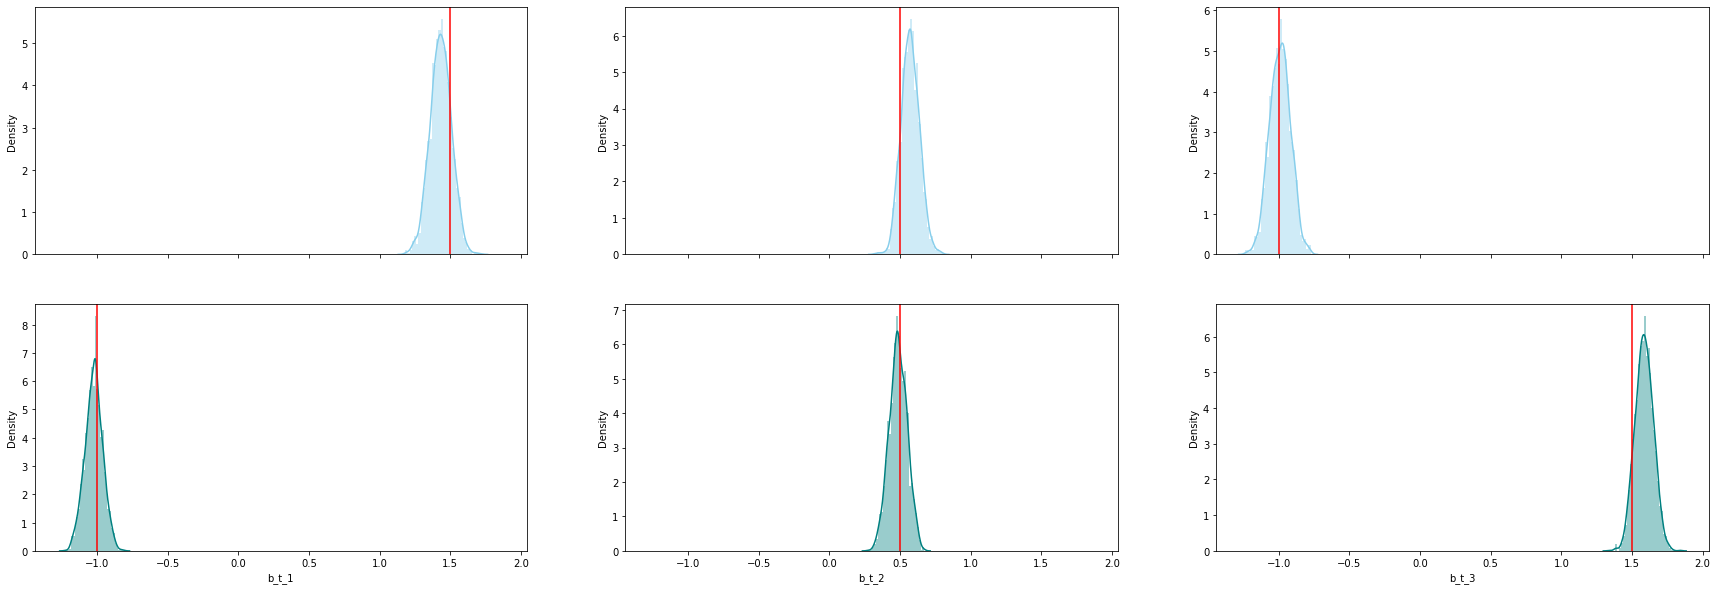

In [33]:
# Plot true vs posterior distribution for each beta
samples = fit2.extract(permuted=True)

post_beta_c = pd.DataFrame(samples['beta_c'], columns=['b_c_1','b_c_2','b_c_3']) # 2000 samples (4 chains x 500 each -> half of inter=1000)
post_beta_t = pd.DataFrame(samples['beta_t'], columns=['b_t_1','b_t_2','b_t_3'])

f, axes = plt.subplots(2, 3, figsize=(30, 10), sharex=True)

plc1 = sns.distplot(post_beta_c["b_c_1"] , color="skyblue", ax=axes[0, 0])
plc1.axvline(r.beta_c[0], color='r')
plc2 = sns.distplot(post_beta_c["b_c_2"] , color="skyblue", ax=axes[0, 1])
plc2.axvline(r.beta_c[1], color='r')
plc3 = sns.distplot(post_beta_c["b_c_3"] , color="skyblue", ax=axes[0, 2])
plc3.axvline(r.beta_c[2], color='r')

plt1 = sns.distplot(post_beta_t["b_t_1"] , color="teal", ax=axes[1, 0])
plt1.axvline(r.beta_t[2], color='r')
plt2 = sns.distplot(post_beta_t["b_t_2"] , color="teal", ax=axes[1, 1])
plt2.axvline(r.beta_t[3], color='r')
plt3 = sns.distplot(post_beta_t["b_t_3"] , color="teal", ax=axes[1, 2])
plt3.axvline(r.beta_t[4], color='r')

plt.show()

## 2.6. Check sample individual treatment uncerteinty

In [34]:
print(samples['y0'][:, 0])
print(samples['y1'][:, 0])

[3.28350628 1.59519159 3.4073404  ... 2.87222679 0.97065183 2.13159442]
[6.26673668 6.26673668 6.26673668 ... 6.26673668 6.26673668 6.26673668]


5.746965831854104


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


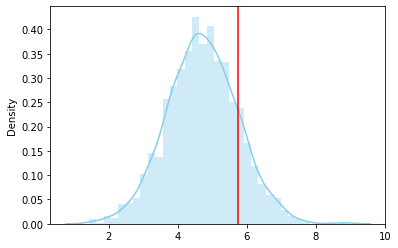

In [35]:
# True treatment effect for first obs relative to distribution of posterior predicted effect
print(df2.tau_unit[0]) # true treatment effect
post_treatment_effect_obs0 = samples['y1'][:, 0] - samples['y0'][:, 0] # posterior predicted treatment effect

plc = sns.distplot(post_treatment_effect_obs0 , color="skyblue")
plc.axvline(df2.tau_unit[0], color='r')


# 3. Counfounded treatment assignment with covariates

Treatment assignment mechanism is: (i) unknown, (ii) not independent of potential outcomes, (iii) probabilistic (conditional on covariates, probability of receiving treatment is strictly between zero and one for all units).

In [36]:
dgp = DataGeneratingProcess(covariates=True, treatment_assignment='c', seed=654)
r = dgp.generate_data()
df3 = r.df
df3

,y_obs,y_mis,y0,y1,tau_unit,w,X1,X2,X3,X4,X5
0,1.323524,2.906735,2.906735,1.323524,-1.583211,1,1.662016,-1.080319,1.215245,-0.249482,0.828267
1,-0.292459,3.514226,3.514226,-0.292459,-3.806685,1,1.199578,1.244795,1.275763,0.672614,0.475124
2,3.398620,1.522005,3.398620,1.522005,-1.876615,0,0.384591,0.053518,-0.208583,0.506197,0.528054
3,3.419448,1.654857,3.419448,1.654857,-1.764591,0,0.728117,1.343644,-0.195296,0.785964,-0.205428
4,2.258443,-0.326446,2.258443,-0.326446,-2.584889,0,0.922173,1.103494,0.044129,0.947856,-0.833358
...,...,...,...,...,...,...,...,...,...,...,...
495,1.804807,0.029928,0.029928,1.804807,1.774880,1,-0.439311,-0.666334,0.013408,-0.693172,0.689773
496,3.591159,0.705931,0.705931,3.591159,2.885229,1,-0.027241,-0.760232,-1.540139,-1.869452,1.310987
497,0.241153,1.243833,1.243833,0.241153,-1.002679,1,1.074499,-0.029395,0.671925,0.504722,0.138325
498,2.555935,-0.062664,-0.062664,2.555935,2.618599,1,-1.640391,0.699869,-0.702645,-1.260732,1.132255


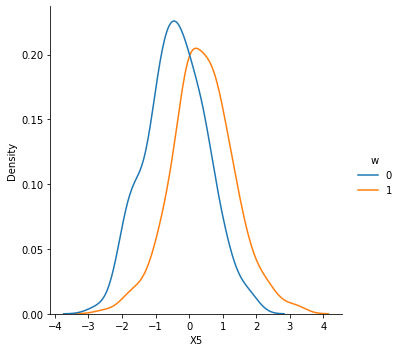

In [37]:
sns.displot(df3, x="X5", hue="w", kind="kde")

## 3.1. Fit Model - Ignoring the observational nature of data 

In [38]:
# Add interaction effects between covariates and treatment
df3[["wX1", "wX2", "wX3", "wX4", "wX5"]] = df3[["X1", "X2", "X3", "X4", "X5"]].multiply(df3["w"], axis="index")
df3

,y_obs,y_mis,y0,y1,tau_unit,w,X1,X2,X3,X4,X5,wX1,wX2,wX3,wX4,wX5
0,1.323524,2.906735,2.906735,1.323524,-1.583211,1,1.662016,-1.080319,1.215245,-0.249482,0.828267,1.662016,-1.080319,1.215245,-0.249482,0.828267
1,-0.292459,3.514226,3.514226,-0.292459,-3.806685,1,1.199578,1.244795,1.275763,0.672614,0.475124,1.199578,1.244795,1.275763,0.672614,0.475124
2,3.398620,1.522005,3.398620,1.522005,-1.876615,0,0.384591,0.053518,-0.208583,0.506197,0.528054,0.000000,0.000000,-0.000000,0.000000,0.000000
3,3.419448,1.654857,3.419448,1.654857,-1.764591,0,0.728117,1.343644,-0.195296,0.785964,-0.205428,0.000000,0.000000,-0.000000,0.000000,-0.000000
4,2.258443,-0.326446,2.258443,-0.326446,-2.584889,0,0.922173,1.103494,0.044129,0.947856,-0.833358,0.000000,0.000000,0.000000,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.804807,0.029928,0.029928,1.804807,1.774880,1,-0.439311,-0.666334,0.013408,-0.693172,0.689773,-0.439311,-0.666334,0.013408,-0.693172,0.689773
496,3.591159,0.705931,0.705931,3.591159,2.885229,1,-0.027241,-0.760232,-1.540139,-1.869452,1.310987,-0.027241,-0.760232,-1.540139,-1.869452,1.310987
497,0.241153,1.243833,1.243833,0.241153,-1.002679,1,1.074499,-0.029395,0.671925,0.504722,0.138325,1.074499,-0.029395,0.671925,0.504722,0.138325
498,2.555935,-0.062664,-0.062664,2.555935,2.618599,1,-1.640391,0.699869,-0.702645,-1.260732,1.132255,-1.640391,0.699869,-0.702645,-1.260732,1.132255


In [39]:
stan_data3 = {'N': df3.shape[0], 
              'y': df3.y_obs,
              'w': df3.w,
              'x': df3[["X1", "X2", "X3", "X4", "X5"]].values,
              'xw_inter': df3[["wX1", "wX2", "wX3", "wX4", "wX5"]].values,
              'N_cov':5,
              'rho':0.0}
sm3 = pystan.StanModel(model_code=simulated_example2)
fit3 = sm3.sampling(data=stan_data3, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4f2f6fe70cd756ee463371850bc520c NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [40]:
#print(fit)
pars = fit3.model_pars
print(pars)
summary_dict = fit3.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df.loc[["alpha", "tau", "tau_fs", "beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]",
        "beta_inter[1]", "beta_inter[2]", "beta_inter[3]", "beta_inter[4]", "beta_inter[5]", "sigma_c", "sigma_t"]]

['alpha', 'beta', 'beta_inter', 'tau', 'sigma_c', 'sigma_t', 'tau_fs', 'y0', 'y1', 'tau_unit']


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,1.079151,0.001291,0.060197,0.962924,1.037605,1.076447,1.119494,1.200490,2174.969988,1.001223
tau,0.166390,0.001834,0.089801,-0.005455,0.104743,0.169940,0.226103,0.339515,2396.950038,1.000635
tau_fs,0.139531,0.001453,0.069694,0.008164,0.092125,0.139883,0.185685,0.278366,2301.268573,1.001146
beta[1],1.492769,0.001258,0.057994,1.378785,1.453972,1.492605,1.533305,1.604386,2125.924898,0.998997
beta[2],0.479722,0.001253,0.061771,0.358549,0.436334,0.480024,0.521349,0.600825,2431.752771,0.999784
beta[3],-1.066465,0.001308,0.058049,-1.176458,-1.105116,-1.066274,-1.028202,-0.949356,1970.020635,1.000233
beta[4],-0.103272,0.001419,0.062351,-0.224238,-0.145619,-0.103017,-0.061199,0.016577,1931.051516,0.999368
beta[5],0.050300,0.001322,0.063115,-0.070927,0.008123,0.049143,0.090561,0.177081,2279.245549,1.000406
beta_inter[1],-1.499759,0.001743,0.088039,-1.676268,-1.559603,-1.498922,-1.439639,-1.330666,2551.651579,0.999335
beta_inter[2],-0.487897,0.001867,0.088161,-0.658775,-0.547588,-0.490904,-0.428821,-0.310656,2230.230568,1.000740


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

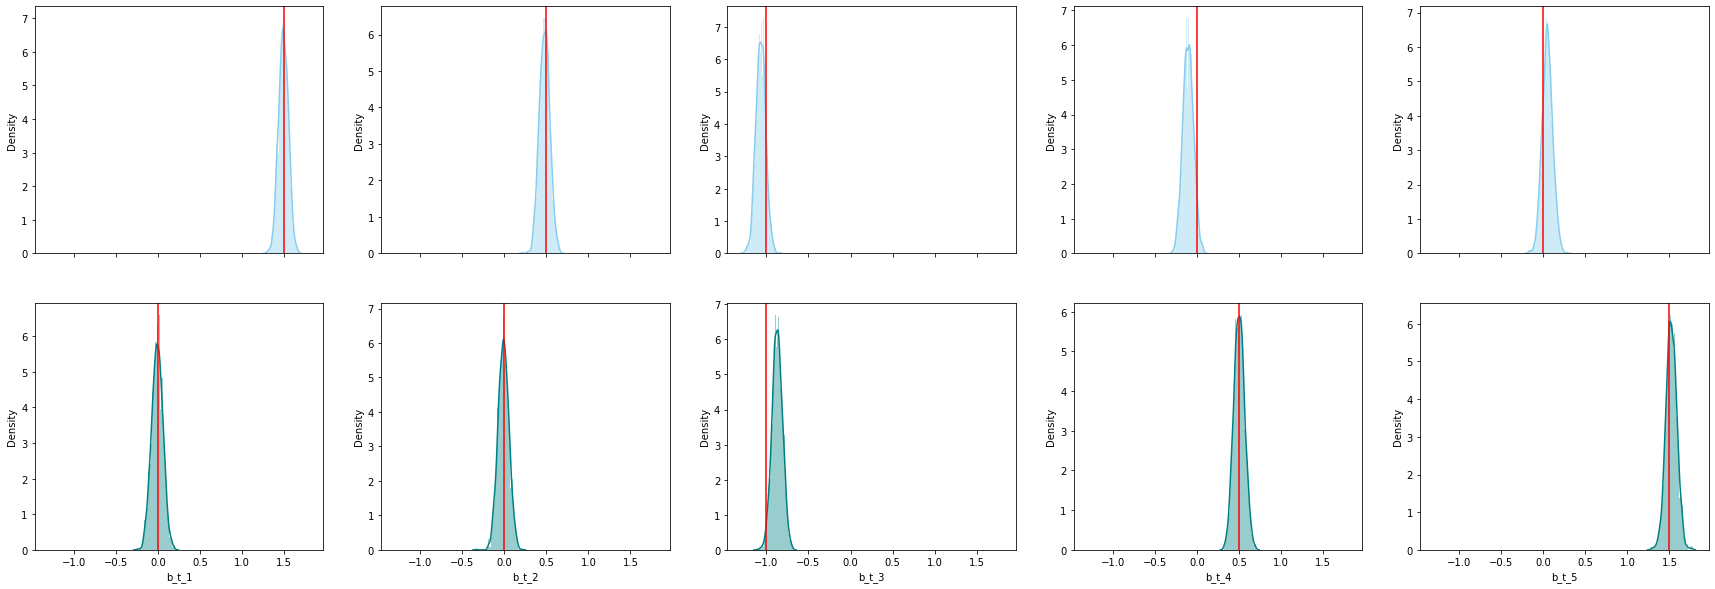

In [41]:
samples = fit3.extract(permuted=True)

# Since the beta_inter represents the difference bewteen beta_t - beta_c, and beta = beta_c, we can derive beta_t = beta_inter + beta_c
post_beta_c = pd.DataFrame(samples['beta'], columns=['b_c_1','b_c_2','b_c_3','b_c_4','b_c_5']) # 2000 samples (4 chains x 500 each -> half of inter=1000)
post_beta_t = pd.DataFrame(samples['beta_inter'] + samples['beta'], columns=['b_t_1','b_t_2','b_t_3','b_t_4','b_t_5'])

# Plot true vs posterior distribution for each beta
f, axes = plt.subplots(2, 5, figsize=(30, 10), sharex=True)

plc1 = sns.distplot(post_beta_c["b_c_1"] , color="skyblue", ax=axes[0, 0])
plc1.axvline(r.beta_c[0], color='r')
plc2 = sns.distplot(post_beta_c["b_c_2"] , color="skyblue", ax=axes[0, 1])
plc2.axvline(r.beta_c[1], color='r')
plc3 = sns.distplot(post_beta_c["b_c_3"] , color="skyblue", ax=axes[0, 2])
plc3.axvline(r.beta_c[2], color='r')
plc4 = sns.distplot(post_beta_c["b_c_4"] , color="skyblue", ax=axes[0, 3])
plc4.axvline(r.beta_c[3], color='r')
plc5 = sns.distplot(post_beta_c["b_c_5"] , color="skyblue", ax=axes[0, 4])
plc5.axvline(r.beta_c[4], color='r')

plt1 = sns.distplot(post_beta_t["b_t_1"] , color="teal", ax=axes[1, 0])
plt1.axvline(r.beta_t[0], color='r')
plt2 = sns.distplot(post_beta_t["b_t_2"] , color="teal", ax=axes[1, 1])
plt2.axvline(r.beta_t[1], color='r')
plt3 = sns.distplot(post_beta_t["b_t_3"] , color="teal", ax=axes[1, 2])
plt3.axvline(r.beta_t[2], color='r')
plt4 = sns.distplot(post_beta_t["b_t_4"] , color="teal", ax=axes[1, 3])
plt4.axvline(r.beta_t[3], color='r')
plt5 = sns.distplot(post_beta_t["b_t_5"] , color="teal", ax=axes[1, 4])
plt5.axvline(r.beta_t[4], color='r')

plt.show()

In [ ]:
# Estimate ps model using bayesian logistic regression
# Add as fix covariate into model

# 4. Counfounded treatment assignment without covariates

In [42]:
dgp = DataGeneratingProcess(seed=12345, covariates = True, treatment_assignment='c')
df4 = dgp.generate_data().df
df4

,y_obs,y_mis,y0,y1,tau_unit,w,X1,X2,X3,X4,X5
0,6.266737,0.519771,0.519771,6.266737,5.746966,1,-0.204708,0.478943,-0.519439,-0.555730,1.965781
1,2.624701,2.383818,2.624701,2.383818,-0.240883,0,1.393406,0.092908,0.281746,0.769023,1.246435
2,3.833803,0.617474,0.617474,3.833803,3.216329,1,1.007189,-1.296221,0.274992,0.228913,1.352917
3,0.922897,2.223415,0.922897,2.223415,1.300517,0,0.886429,-2.001637,-0.371843,1.669025,-0.438570
4,-2.598899,-1.265838,-2.598899,-1.265838,1.333061,0,-0.539741,0.476985,3.248944,-1.021228,-0.577087
...,...,...,...,...,...,...,...,...,...,...,...
495,1.219681,-2.616722,-2.616722,1.219681,3.836402,1,-2.490860,0.468027,-0.343683,-1.428207,0.969402
496,3.055717,3.932656,3.055717,3.932656,0.876938,0,-1.026410,1.097896,-2.216861,-1.681929,-0.375497
497,2.212151,0.241502,0.241502,2.212151,1.970649,1,-0.764114,1.500305,1.256951,1.685727,0.722659
498,1.025913,2.117330,2.117330,1.025913,-1.091416,1,0.940711,0.594283,0.186224,-0.656066,0.379592


In [43]:
stan_data4 = {'N':df4.shape[0], 'y':df4.y_obs, 'w':df4.w, 'rho':0.0}
sm4 = pystan.StanModel(model_code=simulated_example)
fit4 = sm4.sampling(data=stan_data4, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_384bd7d86f218945cd76179a6faaa753 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [44]:
#print(fit)
summary_dict = fit4.summary()
#pars = fit.model_pars
df4 = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

df4.loc[["alpha", "tau", "tau_fs", "sigma_c", "sigma_t"]]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,1.090018,0.003532,0.129829,0.832372,1.004132,1.092271,1.176534,1.352834,1350.858581,0.999575
tau,0.743832,0.005334,0.188644,0.375226,0.616320,0.741077,0.872545,1.117229,1250.862354,1.001238
tau_fs,0.745730,0.003252,0.133306,0.494544,0.655896,0.743171,0.834652,1.010162,1680.005029,0.999455
sigma_c,2.182289,0.001976,0.093106,2.007091,2.119639,2.180530,2.244632,2.366233,2219.016992,0.999373
sigma_t,2.039757,0.002113,0.094757,1.866968,1.974563,2.035822,2.101836,2.245355,2011.593814,0.999888
